## nc 파일 데이터 확인

In [17]:
# pip install xarray

import xarray as xr

file_path = '/home/yurim2/WRF/WRF-4.1.2/test/em_real/wrfout_d01_2024-01-01_04:00:00'
ds = xr.open_dataset(file_path)

print(ds)

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 179, west_east: 179,
                            bottom_top: 32, bottom_top_stag: 33,
                            soil_layers_stag: 4, west_east_stag: 180,
                            south_north_stag: 180, seed_dim_stag: 8)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_s

In [18]:
xlong = ds['XLONG'].isel(Time = 0)

print(xlong)
print(xlong.values)

<xarray.DataArray 'XLONG' (south_north: 179, west_east: 179)>
[32041 values with dtype=float32]
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
    XTIME    datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LONGITUDE, WEST IS NEGATIVE
    units:        degree_east
    stagger:      
[[107.773865 108.0043   108.23511  ... 150.25964  150.48965  150.7193  ]
 [107.71118  107.94223  108.173645 ... 150.32242  150.55304  150.78333 ]
 [107.64813  107.87979  108.11182  ... 150.38556  150.61682  150.84769 ]
 ...
 [ 86.047485  86.4487    86.852295 ... 172.01074  172.40924  172.80536 ]
 [ 85.80841   86.21094   86.615906 ... 172.25     172.64978  173.04712 ]
 [ 85.566956  85.970795  86.377075 ... 172.49158  172.89264  173.29126 ]]


In [16]:
xlong.values[0]

array([126.42999 , 126.4628  , 126.495605, 126.52841 , 126.56122 ,
       126.594055, 126.62686 , 126.65967 , 126.692505, 126.72531 ,
       126.75815 , 126.790955, 126.82379 , 126.8566  , 126.889435,
       126.92224 , 126.95508 , 126.987915, 127.02072 , 127.05356 ,
       127.086365, 127.1192  , 127.15204 , 127.184875, 127.21768 ,
       127.25052 , 127.283356, 127.31616 , 127.349   , 127.381836,
       127.41467 , 127.44751 , 127.48035 , 127.51318 , 127.54602 ,
       127.57886 , 127.611694, 127.64453 , 127.67737 , 127.710205,
       127.74304 , 127.77588 , 127.808716, 127.84155 , 127.87439 ,
       127.90723 , 127.94006 , 127.9729  , 128.00574 , 128.03857 ,
       128.07141 , 128.10425 , 128.13708 , 128.16995 , 128.20279 ,
       128.23563 , 128.2685  , 128.30133 , 128.33417 , 128.367   ,
       128.39984 , 128.43268 , 128.46552 , 128.49838 , 128.53122 ,
       128.56409 , 128.59692 , 128.62976 , 128.6626  , 128.69543 ,
       128.72827 , 128.76114 , 128.79398 , 128.82684 , 128.859

In [50]:
print('u dim : ', ds['U'].dims)

u dim :  ('Time', 'bottom_top', 'south_north', 'west_east_stag')


In [ ]:
def get_mean_dim(ds, var_name, time_index=0):
    """
    주어진 변수의 적절한 차원을 찾아 평균을 계산하여 반환.
    
    Parameters:
    - ds: xarray.Dataset - 데이터셋
    - var_name: str - 변수 이름 (예: 'U' 또는 'V')
    - time_index: int - 시간 인덱스 (기본값은 0)
    
    Returns:
    - xarray.DataArray - 평균이 적용된 변수
    """
    variable = ds[var_name]
    possible_dims = ['bottom_top', 'bottom_top_stag'] 

    for dim in possible_dims:
        if dim in variable.dims:
            return variable.mean(dim=dim).isel(Time=time_index)
    
    raise ValueError(f"{var_name} 변수에서 사용 가능한 차원을 찾을 수 없습니다.")

u = get_mean_dim(ds, 'U', time_index = 0)
print('u_dim : ', u.values)


u_dim :  [[-3.3352785 -3.5699372 -3.5892205 ... -6.308424  -6.3838296 -6.4644513]
 [-2.2302995 -2.3912618 -2.4206657 ... -6.24735   -6.3383875 -6.440873 ]
 [-0.9662071 -0.990472  -1.0034723 ... -6.1830664 -6.282534  -6.3996987]
 ...
 [20.067257  20.166946  20.274221  ... 11.485388  11.201811  11.09444  ]
 [19.37067   19.478798  19.6346    ... 11.6575    11.343041  11.199776 ]
 [18.680733  18.743292  18.810713  ... 11.660259  11.432852  11.3228035]]


## 데이터 db에 적재

In [86]:
import os
import psycopg2
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

In [1]:
def get_db_connection():
    try:
        conn = psycopg2.connect(
            host="172.27.80.1",
            database="calpuff",
            user="postgres",
            password="1201"
        )
        print("데이터베이스에 연결되었습니다.")
        return conn
    except Exception as e:
        print("데이터베이스 연결에 실패했습니다:", e)
        return None

In [ ]:
def insert_data(df):
    conn = get_db_connection()
    if conn is None:
        return
    
    cursor = conn.cursor()
    
    try:
        # 여러 행을 한 번에 삽입
        cursor.executemany(
            "INSERT INTO WRF_2024_01 (timestamp, xlat, xlong, t2, u, v, u_adjusted, v_adjusted) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)",
            df.values.tolist()
        )
        
        conn.commit()
        print('데이터가 성공적으로 삽입되었습니다.')
    except Exception as e:
        print('데이터 삽입에 실패했습니다. : ', e)
    finally:
        cursor.close()
        conn.close()


            
def process_nc_file(file_path, lat_range, long_range):
    files = os.path.basename(file_path)
    parts = files.split('_')
    print(parts)
    if len(parts) >= 4:
        timestamp_str = f"{parts[2]} {parts[3].replace(':', '-')}"
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H-%M-%S')
    else:
        print(f'{file_path}의 형식이 잘못되었습니다.')
        return
    
    data = []
    
    ds = xr.open_dataset(file_path)
    
    xlat = ds['XLAT'].isel(Time = 0)
    xlong = ds['XLONG'].isel(Time = 0)
    t2 = (ds['T2'].isel(Time = 0) - 273.15)
    u = ds['U'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 U 성분
    v = ds['V'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 V 성분
    u_adjusted = 0.5 * (u[:, :-1] + u[:, 1:]) 
    v_adjusted = 0.5 * (v[:-1, :] + v[1:, :])

    
    for i in tqdm(range(xlat.shape[0])):
        for j in range(xlat.shape[1]):
            if xlat[i, j] >= lat_range[0] and xlat[i, j] <= lat_range[1] and xlong[i, j] >= long_range[0] and xlong[i, j] <= long_range[1]:
                data.append([
                timestamp, 
                float(xlat[i, j]), float(xlong[i, j]), 
                float(t2[i, j]), float(u[i, j]), float(v[i, j]),
                float(u_adjusted[i, j-1]) if j > 0 else None,
                float(v_adjusted[i-1, j]) if j > 0 else None
                ])
                
                
	# # 범위 조건을 만족하는 인덱스만 추출
	# lat_idx, lon_idx = np.where(
	# 	(xlat >= lat_range[0]) & (xlat <= lat_range[1]) & 
	# 	(xlong >= long_range[0]) & (xlong <= long_range[1])
	# )

	# for i, j in zip(lat_idx, lon_idx):
	# 	data.append([
	# 		timestamp, 
	# 		float(xlat[i, j]), float(xlong[i, j]), 
	# 		float(t2[i, j]), float(u[i, j]), float(v[i, j]),
	# 		float(u_adjusted[i, j-1]) if j > 0 else 0,
	# 		float(v_adjusted[i-1, j]) if i > 0 else 0
	# 	])

                
    df = pd.DataFrame(data, columns = ['timestamp', 'xlat', 'xlong', 't2', 'u', 'v', 'u_adjusted', 'v_adjusted'])
    df = df.replace({np.nan:None})
    print(df)
    
    insert_data(df)
    ds.close()
    
def process_all_file(folder_path, lat_range, long_range):
    files = [file_name for file_name in os.listdir(folder_path) if file_name.startswith('wrfout_d01_2024-01-01')]
    files = sorted(files)
    
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        process_nc_file(file_path, lat_range, long_range)

In [101]:
folder_path = '/home/yurim2/WRF/SQL'

lat_range = (33.0, 38.6)
long_range = (124.0, 131.0)

process_all_file(folder_path, lat_range, long_range)

['wrfout', 'd01', '2024-01-01', '00:00:00']


100%|██████████| 179/179 [00:32<00:00,  5.57it/s]


     timestamp       xlat       xlong         t2          u         v  \
0   2024-01-01  33.000607  127.395660  11.405243  12.427235 -1.515597   
1   2024-01-01  33.005520  127.721191  12.132690  12.276594 -1.651357   
2   2024-01-01  33.009323  128.046783  12.557983  12.151821 -1.940553   
3   2024-01-01  33.012020  128.372406  12.701904  12.164187 -2.529377   
4   2024-01-01  33.013607  128.698059  12.577728  12.261914 -3.199851   
..         ...        ...         ...        ...        ...       ...   
414 2024-01-01  38.521004  129.380280   4.932861  12.983249 -2.662104   
415 2024-01-01  38.519073  129.734741   4.283295  12.931619 -3.593992   
416 2024-01-01  38.515915  130.089172   3.791473  12.867969 -4.476419   
417 2024-01-01  38.511532  130.443604   3.463898  12.701157 -5.346478   
418 2024-01-01  38.505917  130.797913   3.176331  12.467688 -6.166258   

     u_adjusted  v_adjusted  
0     12.438052   -1.477674  
1     12.351914   -1.610639  
2     12.214208   -1.880194  
3  

100%|██████████| 179/179 [00:34<00:00,  5.13it/s]


              timestamp       xlat       xlong         t2          u  \
0   2024-01-01 01:00:00  33.000607  127.395660  13.785095  11.699675   
1   2024-01-01 01:00:00  33.005520  127.721191  14.222717  11.649768   
2   2024-01-01 01:00:00  33.009323  128.046783  13.499908  11.622591   
3   2024-01-01 01:00:00  33.012020  128.372406  13.462646  11.685760   
4   2024-01-01 01:00:00  33.013607  128.698059  13.244415  11.780026   
..                  ...        ...         ...        ...        ...   
414 2024-01-01 01:00:00  38.521004  129.380280   6.849915  13.609457   
415 2024-01-01 01:00:00  38.519073  129.734741   6.896759  13.492271   
416 2024-01-01 01:00:00  38.515915  130.089172   6.763245  13.384990   
417 2024-01-01 01:00:00  38.511532  130.443604   6.340637  13.187718   
418 2024-01-01 01:00:00  38.505917  130.797913   6.130432  13.009063   

            v  u_adjusted  v_adjusted  
0   -0.570738   11.710630   -0.516723  
1   -0.712067   11.674721   -0.648499  
2   -1.117582  

100%|██████████| 179/179 [00:33<00:00,  5.40it/s]


              timestamp       xlat       xlong         t2          u  \
0   2024-01-01 02:00:00  33.000607  127.395660  13.969879  11.436965   
1   2024-01-01 02:00:00  33.005520  127.721191  14.291779  11.326982   
2   2024-01-01 02:00:00  33.009323  128.046783  13.405212  11.252553   
3   2024-01-01 02:00:00  33.012020  128.372406  13.250275  11.301603   
4   2024-01-01 02:00:00  33.013607  128.698059  13.005463  11.394085   
..                  ...        ...         ...        ...        ...   
414 2024-01-01 02:00:00  38.521004  129.380280   7.075745  14.494550   
415 2024-01-01 02:00:00  38.519073  129.734741   7.068512  14.312270   
416 2024-01-01 02:00:00  38.515915  130.089172   6.986328  14.220737   
417 2024-01-01 02:00:00  38.511532  130.443604   6.379211  13.916253   
418 2024-01-01 02:00:00  38.505917  130.797913   6.150482  13.736775   

            v  u_adjusted  v_adjusted  
0    0.027302   11.460136    0.067371  
1   -0.208398   11.381973   -0.155522  
2   -0.706763  

100%|██████████| 179/179 [00:35<00:00,  5.11it/s]


              timestamp       xlat       xlong         t2          u  \
0   2024-01-01 03:00:00  33.000607  127.395660  14.067322  11.267901   
1   2024-01-01 03:00:00  33.005520  127.721191  14.234070  11.108384   
2   2024-01-01 03:00:00  33.009323  128.046783  13.259552  11.053114   
3   2024-01-01 03:00:00  33.012020  128.372406  13.095734  11.031869   
4   2024-01-01 03:00:00  33.013607  128.698059  12.864990  11.100937   
..                  ...        ...         ...        ...        ...   
414 2024-01-01 03:00:00  38.521004  129.380280   7.387512  15.366673   
415 2024-01-01 03:00:00  38.519073  129.734741   7.317108  15.118845   
416 2024-01-01 03:00:00  38.515915  130.089172   7.378815  14.962893   
417 2024-01-01 03:00:00  38.511532  130.443604   6.615814  14.578564   
418 2024-01-01 03:00:00  38.505917  130.797913   6.308350  14.403169   

            v  u_adjusted  v_adjusted  
0    0.730019   11.288710    0.754795  
1    0.410064   11.188143    0.451016  
2   -0.082411  

100%|██████████| 179/179 [00:33<00:00,  5.36it/s]


              timestamp       xlat       xlong         t2          u  \
0   2024-01-01 04:00:00  33.000607  127.395660  14.174164  11.213890   
1   2024-01-01 04:00:00  33.005520  127.721191  14.225464  11.101024   
2   2024-01-01 04:00:00  33.009323  128.046783  14.161377  11.043307   
3   2024-01-01 04:00:00  33.012020  128.372406  13.040100  10.968405   
4   2024-01-01 04:00:00  33.013607  128.698059  12.795898  11.097264   
..                  ...        ...         ...        ...        ...   
414 2024-01-01 04:00:00  38.521004  129.380280   7.663483  16.148878   
415 2024-01-01 04:00:00  38.519073  129.734741   7.519379  15.878568   
416 2024-01-01 04:00:00  38.515915  130.089172   7.766327  15.732759   
417 2024-01-01 04:00:00  38.511532  130.443604   7.134949  15.384139   
418 2024-01-01 04:00:00  38.505917  130.797913   6.535980  15.212387   

            v  u_adjusted  v_adjusted  
0    1.245463   11.274176    1.232090  
1    0.980993   11.157457    0.967695  
2    0.613364  

## 데이터 불러오기

In [1]:
import psycopg2
def get_db_connection():
    try:
        conn = psycopg2.connect(
            host="172.27.80.1",
            database="calpuff",
            user="postgres",
            password="1201"
        )
        print("데이터베이스에 연결되었습니다.")
        return conn
    except Exception as e:
        print("데이터베이스 연결에 실패했습니다:", e)
        return None

In [2]:
def fetch_data_as_arrays():
    conn = get_db_connection()
    if conn is None:
        return None
    
    cursor = conn.cursor()
    
    try:
        cursor.execute("SELECT timestamp, xlat, xlong, t2, u, v, u_adjusted, v_adjusted FROM WRF_2024_01")
        rows = cursor.fetchall()
        
        timestamps = [row[0] for row in rows]
        xlats = [row[1] for row in rows]
        xlongs = [row[2] for row in rows]
        t2_values = [row[3] for row in rows]
        
        u_values = [row[4] for row in rows]
        v_values = [row[5] for row in rows]
        u_adjusted_values = [row[6] for row in rows]
        v_adjusted_values = [row[7] for row in rows]
        
        return {
            'timestamp': timestamps,
            'xlat': xlats,
            'xlong': xlongs,
            't2': t2_values,
            'u': u_values,
            'v': v_values,
            'u_adjusted': u_adjusted_values,
            'v_adjusted': v_adjusted_values
        }
        
    except Exception as e:
        print('데이터 조회에 실패했습니다 : ', e)
        return None
    finally:
        cursor.close()
        conn.close()

In [3]:
data_arrays = fetch_data_as_arrays()

if data_arrays is None:
    print("데이터를 불러오지 못했습니다.")
    exit()

데이터베이스에 연결되었습니다.


In [5]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

df = pd.DataFrame(data_arrays)
df['timestamp'] = pd.to_datetime(df['timestamp'])
daily_hourly_data = {(day, hour): df[(df['timestamp'].dt.day == day) & (df['timestamp'].dt.hour == hour)]
                     for day in df['timestamp'].dt.day.unique()
                     for hour in range(24)}

df

,timestamp,xlat,xlong,t2,u,v,u_adjusted,v_adjusted
0,2024-01-01 00:00:00,33.000607,127.395660,11.405243,12.427235,-1.515597,12.438052,-1.477674
1,2024-01-01 00:00:00,33.005520,127.721191,12.132690,12.276594,-1.651357,12.351914,-1.610639
2,2024-01-01 00:00:00,33.009323,128.046783,12.557983,12.151821,-1.940553,12.214208,-1.880194
3,2024-01-01 00:00:00,33.012020,128.372406,12.701904,12.164187,-2.529377,12.158005,-2.413202
4,2024-01-01 00:00:00,33.013607,128.698059,12.577728,12.261914,-3.199851,12.213051,-3.019987
...,...,...,...,...,...,...,...,...
2090,2024-01-01 04:00:00,38.521004,129.380280,7.663483,16.148878,1.828447,16.233738,1.766849
2091,2024-01-01 04:00:00,38.519073,129.734741,7.519379,15.878568,1.213007,16.013723,1.132973
2092,2024-01-01 04:00:00,38.515915,130.089172,7.766327,15.732759,0.525844,15.805663,0.444433
2093,2024-01-01 04:00:00,38.511532,130.443604,7.134949,15.384139,-0.036426,15.558449,-0.148114


In [7]:
df.to_csv('./nc_to_csv.csv', index = 0)

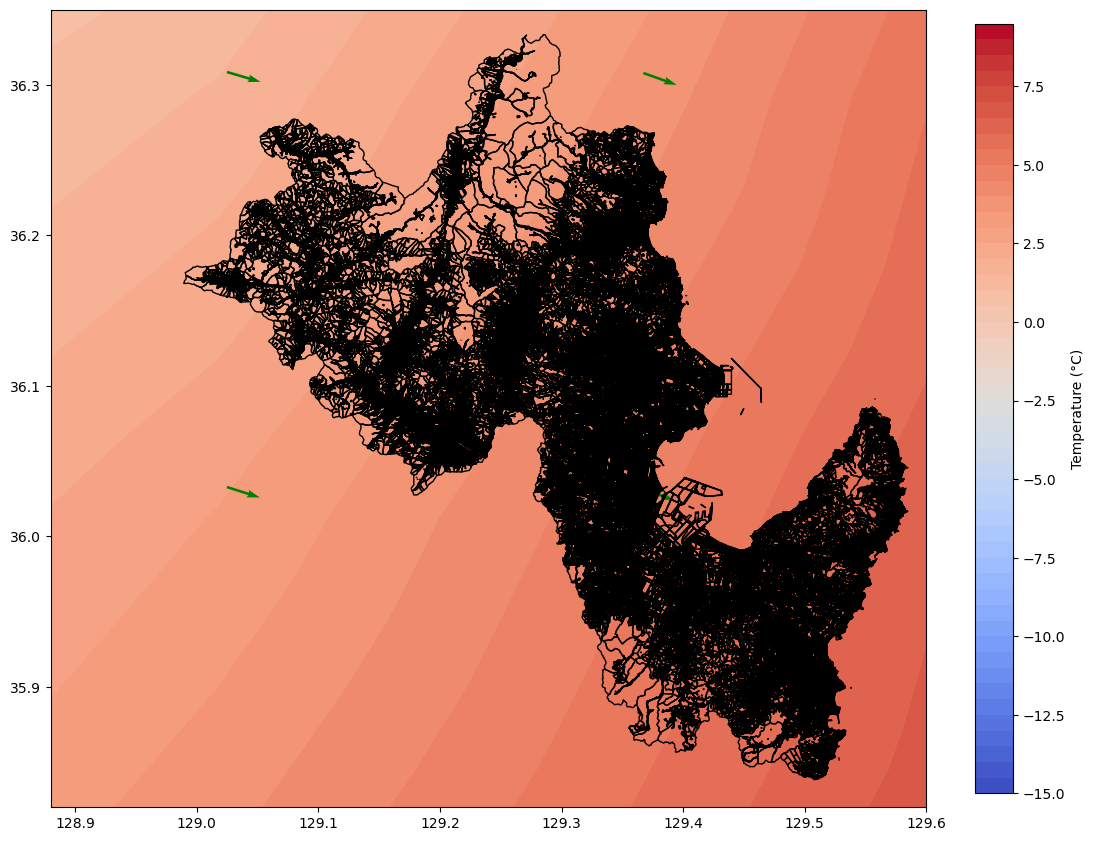

KeyboardInterrupt: 

In [51]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import pandas as pd

# Shapefile 불러오기 (로드뷰용)
shapefile_path = "/home/yurim2/WRF/pohang_shp/pohang.shp"
gdf = gpd.read_file(shapefile_path)

# 데이터프레임 로드
df = pd.DataFrame(data_arrays)
df['timestamp'] = pd.to_datetime(df['timestamp'])
daily_hourly_data = {(day, hour): df[(df['timestamp'].dt.day == day) & (df['timestamp'].dt.hour == hour)]
                     for day in df['timestamp'].dt.day.unique()
                     for hour in range(24)}

# Plot 설정
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(1, 2, width_ratios=[4, 0.1])

ax_plot = fig.add_subplot(gs[0])
ax_plot.set_xlim(128.88, 129.6)
ax_plot.set_ylim(35.82, 36.35)

levels = np.arange(-15.0, 10.0, 0.5)

# 초기 프레임 설정
initial_data = daily_hourly_data[(1, 0)]
xlong_grid, xlat_grid = np.meshgrid(
    np.linspace(initial_data['xlong'].min(), initial_data['xlong'].max(), 100),
    np.linspace(initial_data['xlat'].min(), initial_data['xlat'].max(), 100)
)
t2_grid = griddata(
    (initial_data['xlong'], initial_data['xlat']),
    initial_data['t2'],
    (xlong_grid, xlat_grid),
    method='linear'
)

contour = ax_plot.contourf(xlong_grid, xlat_grid, t2_grid, cmap='coolwarm', levels=levels)
colorbar = fig.colorbar(contour, ax=ax_plot, label='Temperature (°C)', fraction=0.04, pad=0.05)
quiver = ax_plot.quiver(initial_data['xlong'], initial_data['xlat'], initial_data['u_adjusted'], initial_data['v_adjusted'], scale=300, color='green')

# 지도 경계선 추가
gdf.plot(ax=ax_plot, edgecolor='black', facecolor='none')

# 초기 설정에서 contour와 quiver를 None으로 설정
contour = None
quiver = None

# Update function for animation
def update(frame):
    global contour, quiver

    # 날짜와 시간 계산
    day = frame // 24 + 1
    hour = frame % 24

    # 이전 contour와 quiver를 안전하게 제거
    try:
        if contour is not None:
            for c in contour.collections:
                c.remove()
        if quiver is not None:
            quiver.remove()
    except ValueError:
        # 오류 발생 시 패스하고 넘어감
        pass

    # 현재 날짜와 시간대의 데이터
    data = daily_hourly_data.get((day, hour), pd.DataFrame())

    if not data.empty:
        # 온도 데이터 그리드로 보간
        t2_grid = griddata(
            (data['xlong'], data['xlat']),
            data['t2'],
            (xlong_grid, xlat_grid),
            method='linear'
        )

        # 새 contour와 quiver 생성
        contour = ax_plot.contourf(xlong_grid, xlat_grid, t2_grid, cmap='coolwarm', levels=levels, vmin=-20, vmax=20)
        quiver = ax_plot.quiver(
            data['xlong'], data['xlat'],
            data['u_adjusted'], data['v_adjusted'],
            scale=300, color='green', width=0.0025, headwidth=3, headlength=5, headaxislength=4.5
        )

        ax_plot.set_title(f'Date: 2024-01-{day:02d} Time: {hour:02d}:00')
    else:
        ax_plot.set_title(f'Date: 2024-01-{day:02d} Time: {hour:02d}:00 (No Data)')

    ax_plot.set_xlabel('Longitude')
    ax_plot.set_ylabel('Latitude')

# Animation 설정
total_frames = 31 * 24  # 31일 * 24시간
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=2000, repeat=True)

# Show animation
plt.show()

# Animation 저장 (MP4 형식)
writer = animation.FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('./2024_01_animation.mp4', writer=writer)

# GIF 저장
ani.save('./2024_01_animation.gif', writer='imagemagick')


In [1]:
# quiver로 파일 1개만 nc 파일

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from datetime import datetime
from tqdm import tqdm

def setup_map():
    """Setup the map with required features"""
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=3, edgecolor='black')
    ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5)
    
    return fig, ax

def process_wrf_data(filename):
    """Process WRF output data"""
    # Open the WRF netCDF file
    ds = xr.open_dataset(filename)
    
    # Get time dimension
    times = ds.Times.values
    ntimes = len(times)
    
    print(f"Number of time steps: {ntimes}")
    
    # Process data for every other time step
    for it in range(0, ntimes, 2):
        time = times[it]
        print(f"Working on time: {time}")
        
        # Extract variables
        t2 = ds.T2.isel(Time=it).values - 273.15  # Convert to Celsius
        u10 = ds.U10.isel(Time=it).values * 1.94836  # Convert to knots
        v10 = ds.V10.isel(Time=it).values * 1.94836  # Convert to knots
        
        
        # Create visualization
        plot_weather_map(ds, time, t2, u10, v10)
        
    ds.close()

def plot_weather_map(ds, time, t2, u10, v10):
    """Create weather map visualization"""
    # Setup two subplots - one for temperature, one for dewpoint
    for plot_type in tqdm(['temperature', 'dewpoint']):
        fig, ax = setup_map()
        
        # Set map extent based on domain
        lat = ds.XLAT.values[0, :, :]
        lon = ds.XLONG.values[0, :, :]
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
        
        if plot_type == 'temperature':
            # Plot temperature
            levels = np.arange(-10, 31, 5)
            temp_contour = ax.contourf(lon, lat, t2, levels=levels, 
                                     cmap='RdYlBu_r', transform=ccrs.PlateCarree())
            plt.colorbar(temp_contour, label='Temperature (°C)')
            
            # Plot SLP
            slp_levels = np.arange(1000, 1061, 2)
            slp_contour = ax.contour(lon, lat, levels=slp_levels,
                                   colors='blue', transform=ccrs.PlateCarree())
            plt.clabel(slp_contour, inline=True, fmt='%1.0f', fontsize=10)
        else:
            # Plot dewpoint
            levels = np.arange(-10, 31, 5)
            td_contour = ax.contourf(lon, lat, levels=levels,
                                   cmap='RdYlBu_r', transform=ccrs.PlateCarree())
            plt.colorbar(td_contour, label='Dewpoint Temperature (°C)')
        
        # Plot wind vectors (subsample for clarity)
        skip = 4  # Adjust this value to change vector density
        ax.quiver(lon[::skip, ::skip], lat[::skip, ::skip],
                 u10[::skip, ::skip], v10[::skip, ::skip],
                 transform=ccrs.PlateCarree(), scale=120)
        
        # Add title
        time_str = time.decode('utf-8') if isinstance(time, bytes) else str(time)
        plt.title(f'REAL-TIME WRF - {time_str}\n{"Temperature" if plot_type == "temperature" else "Dewpoint"}')
        
        # Save figure
        plt.savefig(f'Surface_{plot_type}_{time_str}.png', bbox_inches='tight', dpi=300)
        plt.close()

if __name__ == "__main__":
    wrf_file = "/home/yurim2/WRF/SQL/wrfout_d01_2024-01-01_01:00:00"
    process_wrf_data(wrf_file)

Number of time steps: 1
Working on time: b'2024-01-01_01:00:00'


  0%|          | 0/2 [00:00<?, ?it/s]

: 

In [1]:
import cartopy
print(cartopy.__version__)

0.21.1


In [1]:
# quiver로 여러개(에니메이션) nc 파일

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from metpy.units import units
from metpy.calc import smooth_n_point
from datetime import datetime
import glob
from matplotlib.animation import FuncAnimation
import os
import pandas as pd

class WRFAnimator:
    def __init__(self, file_pattern="./wrfout_d01_*"):
        """
        초기화 함수
        file_pattern: nc 파일들의 패턴 (예: "./wrfout_d01_*")
        """
        self.file_pattern = file_pattern
        self.files = sorted(glob.glob(file_pattern))
        if not self.files:
            raise ValueError(f"No files found matching pattern: {file_pattern}")
        
        # 첫 번째 파일로 좌표 정보 초기화
        self.ds = xr.open_dataset(self.files[0])
        self.lat = self.ds.XLAT.values[0, :, :]
        self.lon = self.ds.XLONG.values[0, :, :]
        
        # 시각화를 위한 설정
        self.setup_plots()
        
    def setup_plots(self):
        """시각화 설정"""
        # 온도와 이슬점 플롯을 위한 두 개의 서브플롯 생성
        self.fig = plt.figure(figsize=(20, 10))
        
        # 온도 플롯
        self.ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
        self.setup_map(self.ax1)
        
        # 이슬점 플롯
        self.ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
        self.setup_map(self.ax2)
        
        # 컬러바와 등압선을 위한 초기 더미 데이터
        self.temp_levels = np.arange(-10, 31, 5)
        self.slp_levels = np.arange(1000, 1061, 2)
        
        # 초기 플롯 생성
        dummy_data = np.zeros_like(self.lat)
        
        # 온도 플롯 초기화
        self.temp_contour = self.ax1.contourf(self.lon, self.lat, dummy_data,
                                            levels=self.temp_levels,
                                            cmap='RdYlBu_r',
                                            transform=ccrs.PlateCarree())
        self.slp_contour = self.ax1.contour(self.lon, self.lat, dummy_data,
                                          levels=self.slp_levels,
                                          colors='blue',
                                          transform=ccrs.PlateCarree())
        plt.colorbar(self.temp_contour, ax=self.ax1, label='Temperature (°C)')
        
        
        # 바람 벡터 초기화 (서브샘플링)
        skip = 4
        self.quiver1 = self.ax1.quiver(self.lon[::skip, ::skip], self.lat[::skip, ::skip],
                                     dummy_data[::skip, ::skip], dummy_data[::skip, ::skip],
                                     transform=ccrs.PlateCarree(), scale=120)
        self.quiver2 = self.ax2.quiver(self.lon[::skip, ::skip], self.lat[::skip, ::skip],
                                     dummy_data[::skip, ::skip], dummy_data[::skip, ::skip],
                                     transform=ccrs.PlateCarree(), scale=120)

    def setup_map(self, ax):
        """지도 기본 설정"""
        ax.add_feature(cfeature.COASTLINE, linewidth=3, edgecolor='black')
        ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
        ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5)
        ax.set_extent([self.lon.min(), self.lon.max(),
                      self.lat.min(), self.lat.max()],
                     crs=ccrs.PlateCarree())

    def update(self, frame):
        """애니메이션 프레임 업데이트"""
        file_idx = frame // 2  # 파일 인덱스
        time_idx = frame % 2   # 파일 내 시간 인덱스
        
        if file_idx >= len(self.files):
            return
        
        # 데이터 로드
        ds = xr.open_dataset(self.files[file_idx])
        
        # 변수 추출
        slp = ds.slp.isel(Time=time_idx).values
        t2 = ds.T2.isel(Time=time_idx).values - 273.15
        u10 = ds.U10.isel(Time=time_idx).values * 1.94836
        v10 = ds.V10.isel(Time=time_idx).values * 1.94836
        
        # SLP 평활화
        slp_smoothed = smooth_n_point(slp, 3)
        
        # 기존 컨투어 제거
        for coll in self.ax1.collections + self.ax2.collections:
            coll.remove()
        
        # 온도 플롯 업데이트
        self.temp_contour = self.ax1.contourf(self.lon, self.lat, t2,
                                            levels=self.temp_levels,
                                            cmap='RdYlBu_r',
                                            transform=ccrs.PlateCarree())
        self.slp_contour = self.ax1.contour(self.lon, self.lat, slp_smoothed,
                                          levels=self.slp_levels,
                                          colors='blue',
                                          transform=ccrs.PlateCarree())

        # 바람 벡터 업데이트
        skip = 4
        self.quiver1.set_UVC(u10[::skip, ::skip], v10[::skip, ::skip])
        self.quiver2.set_UVC(u10[::skip, ::skip], v10[::skip, ::skip])
        
        # 제목 업데이트
        time_str = ds.Times[time_idx].values.decode('utf-8')
        self.ax1.set_title(f'Temperature and SLP - {time_str}')
        self.ax2.set_title(f'Dewpoint - {time_str}')
        
        ds.close()
        return self.temp_contour, self.slp_contour, self.td_contour, self.quiver1, self.quiver2

    def create_animation(self, output_file='wrf_animation.mp4', fps=2):
        """애니메이션 생성 및 저장"""
        total_frames = len(self.files) * 2  # 각 파일당 2개의 시간
        anim = FuncAnimation(self.fig, self.update, frames=total_frames,
                           interval=500, blit=True)
        
        # MP4 저장
        anim.save(output_file, fps=fps, extra_args=['-vcodec', 'libx264'])
        plt.close()

def main():
    # WRF 파일 패턴 설정
    file_pattern = "./wrfout_d01_2024-*"  # 적절한 파일 패턴으로 수정하세요
    
    try:
        # 애니메이터 객체 생성 및 애니메이션 실행
        animator = WRFAnimator(file_pattern)
        animator.create_animation(output_file='wrf_animation.mp4', fps=2)
        print("Animation created successfully!")
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")

if __name__ == "__main__":
    main()

: 

In [ ]:
# 파일 패턴을 자신의 환경에 맞게 수정
file_pattern = "./wrfout_d01_2024-*"  
# 애니메이션 생성
animator = WRFAnimator(file_pattern)
animator.create_animation(output_file='wrf_animation.mp4', fps=2)

In [1]:
# 데이터프레임으로

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.animation import FuncAnimation
import pandas as pd
from datetime import datetime

class WeatherAnimator:
    def __init__(self, df):
        """
        초기화 함수
        df: DataFrame (timestamp, xlat, xlong, t2, u, v, u_adjusted, v_adjusted 컬럼 포함)
        """
        self.df = df
        
        # 시간별로 데이터 그룹화
        self.unique_times = df['timestamp'].unique()
        
        # 격자 생성을 위한 좌표 준비
        self.lats = df['xlat'].unique()
        self.lons = df['xlong'].unique()
        self.lat_grid, self.lon_grid = np.meshgrid(self.lats, self.lons)
        
        # 시각화 설정
        self.setup_plots()
        
    def setup_plots(self):
        """시각화 설정"""
        self.fig = plt.figure(figsize=(15, 8))
        self.ax = plt.axes(projection=ccrs.PlateCarree())
        
        # 지도 기본 설정
        self.setup_map()
        
        # 초기 더미 데이터로 플롯 생성
        dummy_data = np.zeros(self.lat_grid.shape)
        
        # 온도 컨투어 초기화
        self.temp_levels = np.linspace(self.df['t2'].min(), self.df['t2'].max(), 15)
        self.temp_contour = self.ax.contourf(self.lon_grid, self.lat_grid, dummy_data,
                                           levels=self.temp_levels,
                                           cmap='RdYlBu_r',
                                           transform=ccrs.PlateCarree())
        
        # 바람 벡터 초기화
        skip = 4  # 벡터 표시 간격
        self.quiver = self.ax.quiver(self.lon_grid[::skip, ::skip],
                                   self.lat_grid[::skip, ::skip],
                                   dummy_data[::skip, ::skip],
                                   dummy_data[::skip, ::skip],
                                   transform=ccrs.PlateCarree(),
                                   scale=50)
        
        # 컬러바 추가
        plt.colorbar(self.temp_contour, ax=self.ax, label='Temperature (°C)')
        
    def setup_map(self):
        """지도 기본 설정"""
        self.ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')
        self.ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
        self.ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
        self.ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
        
        # 지도 범위 설정
        self.ax.set_extent([self.lons.min(), self.lons.max(),
                          self.lats.min(), self.lats.max()],
                         crs=ccrs.PlateCarree())

    def reshape_data(self, time):
        """특정 시간의 데이터를 격자 형태로 변환"""
        time_data = self.df[self.df['timestamp'] == time]
        
        t2_grid = np.zeros(self.lat_grid.shape)
        u_grid = np.zeros(self.lat_grid.shape)
        v_grid = np.zeros(self.lat_grid.shape)
        
        for idx, row in time_data.iterrows():
            lat_idx = np.where(self.lats == row['xlat'])[0][0]
            lon_idx = np.where(self.lons == row['xlong'])[0][0]
            
            t2_grid[lon_idx, lat_idx] = row['t2']
            u_grid[lon_idx, lat_idx] = row['u_adjusted']
            v_grid[lon_idx, lat_idx] = row['v_adjusted']
        
        return t2_grid, u_grid, v_grid

    def update(self, frame):
        """애니메이션 프레임 업데이트"""
        # 현재 시간의 데이터 가져오기
        current_time = self.unique_times[frame]
        t2_grid, u_grid, v_grid = self.reshape_data(current_time)
        
        # 기존 컨투어 제거
        for collection in self.ax.collections:
            collection.remove()
        
        # 온도 컨투어 업데이트
        self.temp_contour = self.ax.contourf(self.lon_grid, self.lat_grid, t2_grid,
                                           levels=self.temp_levels,
                                           cmap='RdYlBu_r',
                                           transform=ccrs.PlateCarree())
        
        # 바람 벡터 업데이트
        skip = 4
        self.quiver.set_UVC(u_grid[::skip, ::skip], v_grid[::skip, ::skip])
        
        # 제목 업데이트
        time_str = pd.to_datetime(current_time).strftime('%Y-%m-%d %H:%M:%S')
        self.ax.set_title(f'Temperature and Wind - {time_str}')
        
        return self.temp_contour, self.quiver

    def create_animation(self, output_file='weather_animation.mp4', fps=5):
        """애니메이션 생성 및 저장"""
        anim = FuncAnimation(self.fig, self.update,
                           frames=len(self.unique_times),
                           interval=200, blit=True)
        
        anim.save(output_file, fps=fps, extra_args=['-vcodec', 'libx264'])
        plt.close()

def main():
    # 예시 데이터프레임 생성 (실제로는 DB에서 가져온 데이터 사용)
    df = pd.read_csv('/home/yurim2/WRF/SQL/nc_to_csv.csv')  # 또는 DB에서 직접 데이터 로드
    
    try:
        # 애니메이터 객체 생성 및 애니메이션 실행
        animator = WeatherAnimator(df)
        animator.create_animation(output_file='weather_animation.mp4', fps=5)
        print("Animation created successfully!")
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")

if __name__ == "__main__":
    main()

: 

In [1]:

animator = WRFAnimator('/home/yurim2/WRF/SQL/nc_to_csv.csv')
animator.create_animation(output_file='wrf_db_animation.mp4', fps=2)

NameError: name 'WRFAnimator' is not defined

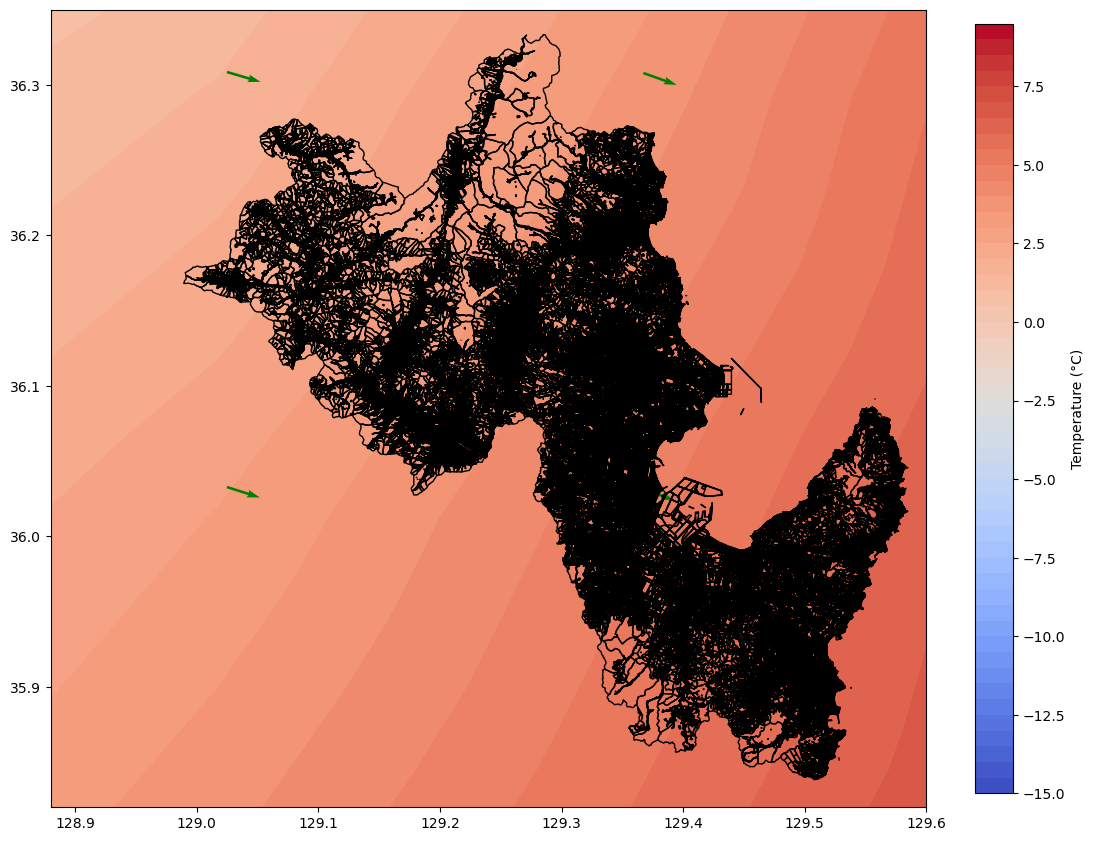

In [ ]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import pandas as pd

# Shapefile 불러오기 (로드뷰용)
shapefile_path = "/home/yurim2/WRF/pohang_shp/pohang.shp"
gdf = gpd.read_file(shapefile_path)

# 데이터프레임 로드
df = pd.DataFrame(data_arrays)
df['timestamp'] = pd.to_datetime(df['timestamp'])
daily_hourly_data = {(day, hour): df[(df['timestamp'].dt.day == day) & (df['timestamp'].dt.hour == hour)]
                     for day in df['timestamp'].dt.day.unique()
                     for hour in range(24)}

# Plot 설정
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(1, 2, width_ratios=[4, 0.1])

ax_plot = fig.add_subplot(gs[0])
ax_plot.set_xlim(128.88, 129.6)
ax_plot.set_ylim(35.82, 36.35)

levels = np.arange(-15.0, 10.0, 0.5)

# 초기 프레임 설정
initial_data = daily_hourly_data[(1, 0)]
xlong_grid, xlat_grid = np.meshgrid(
    np.linspace(initial_data['xlong'].min(), initial_data['xlong'].max(), 100),
    np.linspace(initial_data['xlat'].min(), initial_data['xlat'].max(), 100)
)
t2_grid = griddata(
    (initial_data['xlong'], initial_data['xlat']),
    initial_data['t2'],
    (xlong_grid, xlat_grid),
    method='linear'
)

contour = ax_plot.contourf(xlong_grid, xlat_grid, t2_grid, cmap='coolwarm', levels=levels)
colorbar = fig.colorbar(contour, ax=ax_plot, label='Temperature (°C)', fraction=0.04, pad=0.05)
quiver = ax_plot.quiver(initial_data['xlong'], initial_data['xlat'], initial_data['u_adjusted'], initial_data['v_adjusted'], scale=300, color='green')

# 지도 경계선 추가
gdf.plot(ax=ax_plot, edgecolor='black', facecolor='none')

# 초기 설정에서 contour와 quiver를 None으로 설정
contour = None
quiver = None

# Update function for animation
def update(frame):
    global contour, quiver

    # 날짜와 시간 계산
    day = frame // 24 + 1
    hour = frame % 24

    # 이전 contour와 quiver를 안전하게 제거
    try:
        if contour is not None:
            for c in contour.collections:
                c.remove()
        if quiver is not None:
            quiver.remove()
    except ValueError:
        # 오류 발생 시 패스하고 넘어감
        pass

    # 현재 날짜와 시간대의 데이터
    data = daily_hourly_data.get((day, hour), pd.DataFrame())

    if not data.empty:
        # 온도 데이터 그리드로 보간
        t2_grid = griddata(
            (data['xlong'], data['xlat']),
            data['t2'],
            (xlong_grid, xlat_grid),
            method='linear'
        )

        # 새 contour와 quiver 생성
        contour = ax_plot.contourf(xlong_grid, xlat_grid, t2_grid, cmap='coolwarm', levels=levels, vmin=-20, vmax=20)
        quiver = ax_plot.quiver(
            data['xlong'], data['xlat'],
            data['u_adjusted'], data['v_adjusted'],
            scale=300, color='green', width=0.0025, headwidth=3, headlength=5, headaxislength=4.5
        )

        ax_plot.set_title(f'Date: 2024-01-{day:02d} Time: {hour:02d}:00')
    else:
        ax_plot.set_title(f'Date: 2024-01-{day:02d} Time: {hour:02d}:00 (No Data)')

    ax_plot.set_xlabel('Longitude')
    ax_plot.set_ylabel('Latitude')

# Animation 설정
total_frames = 31 * 24  # 31일 * 24시간
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=2000, repeat=True)

# Show animation
plt.show()

# Animation 저장 (MP4 형식)
writer = animation.FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('./2024_01_animation.mp4', writer=writer)

# GIF 저장
ani.save('./2024_01_animation.gif', writer='imagemagick')


### 그래프 그리기

In [42]:
def fetch_data_as_arrays():
    conn = get_db_connection()
    if conn is None:
        return None
    
    cursor = conn.cursor()
    
    try:
        cursor.execute("SELECT timestamp, xlat, xlong, t2, u, v, u_adjusted, v_adjusted FROM WRF_2024_01")
        rows = cursor.fetchall()
        
        timestamps = [row[0] for row in rows]
        xlats = [row[1] for row in rows]
        xlongs = [row[2] for row in rows]
        t2_values = [row[3] for row in rows]
        u_values = [row[4] for row in rows]
        v_values = [row[5] for row in rows]
        u_adjusted_values = [row[6] for row in rows]
        v_adjusted_values = [row[7] for row in rows]
        
        return {
            'timestamp': timestamps,
            'xlat': xlats,
            'xlong': xlongs,
            't2': t2_values,
            'u': u_values,
            'v': v_values,
            'u_adjusted': u_adjusted_values,
            'v_adjusted': v_adjusted_values
        }
        
    except Exception as e:
        print('데이터 조회에 실패했습니다 : ', e)
        return None
    finally:
        cursor.close()
        conn.close()

In [43]:
pohang_data_arrays = fetch_data_as_arrays()

if data_arrays is None:
    print("데이터를 불러오지 못했습니다.")
    exit()

데이터베이스에 연결되었습니다.


In [ ]:
import folium
import pandas as pd
import numpy as np
import json
from datetime import datetime

# 데이터 확인 및 전처리
pohang_df = pd.DataFrame(pohang_data_arrays)
pohang_df['timestamp'] = pd.to_datetime(pohang_df['timestamp'])

# 기본 지도 생성
map_pohang = folium.Map(location=[35.82, 129.25], zoom_start=10)

# 데이터 프레임을 JSON 직렬화 가능한 형태로 변환
time_frames = []
for _, row in pohang_df.iterrows():
    frame_data = {
        'day': int(row['timestamp'].day),
        'hour': int(row['timestamp'].hour),
        'data': [{
            'latitude': float(row['xlat']),
            'longitude': float(row['xlong']),
            'temperature': float(row['t2']),
            'u': float(row['u_adjusted']),
            'v': float(row['v_adjusted'])
        }]
    }
    time_frames.append(frame_data)

# JSON 직렬화 가능한지 확인
try:
    time_frames_json = json.dumps(time_frames)
    print("JSON 변환 성공")
except Exception as e:
    print(f"JSON 변환 실패: {e}")
    raise

# JavaScript 코드 수정
js_code = f"""
<script>
    // 데이터 로드 및 파싱
    var timeFrames = {time_frames_json};
    var currentFrame = 0;
    var markers = [];
    
    function updateMap() {{
        // 이전 마커 제거
        markers.forEach(function(marker) {{
            map.removeLayer(marker);
        }});
        markers = [];
        
        var frame = timeFrames[currentFrame];
        
        // 프레임 데이터 확인
        console.log('Current frame:', frame);
        
        frame.data.forEach(function(point) {{
            // 온도 마커
            var tempColor = getTemperatureColor(point.temperature);
            
            var tempMarker = L.circleMarker([point.latitude, point.longitude], {{
                radius: 5,
                fillColor: tempColor,
                color: '#000',
                weight: 1,
                opacity: 1,
                fillOpacity: 0.8
            }}).addTo(map);
            
            tempMarker.bindTooltip(point.temperature.toFixed(1) + '°C', {{
                permanent: true,
                direction: 'top'
            }});
            
            markers.push(tempMarker);
            
            // 바람 화살표
            var windLength = Math.sqrt(point.u * point.u + point.v * point.v);
            if (windLength > 0) {{
                var scaleFactor = 0.01;
                var endLat = point.latitude + (point.v * scaleFactor);
                var endLon = point.longitude + (point.u * scaleFactor);
                
                var arrow = L.polyline(
                    [[point.latitude, point.longitude], [endLat, endLon]],
                    {{color: 'green', weight: 2}}
                ).addTo(map);
                
                markers.push(arrow);
            }}
        }});
        
        // 시간 표시 업데이트
        document.getElementById('time-display').innerHTML = 
            `Day: ${{frame.day}}, Hour: ${{frame.hour}}:00`;
            
        currentFrame = (currentFrame + 1) % timeFrames.length;
    }}
    
    function getTemperatureColor(temp) {{
        if (temp > 20) return '#ff0000';
        if (temp > 10) return '#ff8c00';
        if (temp > 0) return '#ffff00';
        return '#0000ff';
    }}
    
    // 시간 표시 div 추가
    var timeDisplay = document.createElement('div');
    timeDisplay.id = 'time-display';
    timeDisplay.style.cssText = 'position: absolute; top: 10px; right: 10px; background: white; padding: 5px; border: 1px solid black; z-index: 1000;';
    document.querySelector('.folium-map').appendChild(timeDisplay);
    
    // 애니메이션 시작 전 초기 데이터 확인
    console.log('Total frames:', timeFrames.length);
    console.log('First frame:', timeFrames[0]);
    
    // 애니메이션 시작
    setInterval(updateMap, 1000);
</script>
"""

map_pohang.get_root().html.add_child(folium.Element(js_code))

# 디버깅을 위한 데이터 출력
print(f"총 프레임 수: {len(time_frames)}")
print("첫 번째 프레임 샘플:", time_frames[0])

map_pohang.save('./pohang_animation_map.html')
map_pohang

In [ ]:
import folium
import xarray as xr
import numpy as np
from branca.colormap import LinearColormap

# NetCDF 파일을 xarray로 읽기
wrf_file = '/home/yurim2/WRF/SQL/wrfout_d01_2024-01-01_00:00:00'  # WRF 결과 파일의 경로
ds = xr.open_dataset(wrf_file)

# 필요한 변수 추출 (예시: 첫 시간 스텝의 데이터)
temperature = ds['T2'][0, :, :].values - 273.15  # T2는 켈빈으로 저장되므로 섭씨로 변환
u_wind = ds['U10'][0, :, :].values  # 지면 바람의 u 성분
v_wind = ds['V10'][0, :, :].values  # 지면 바람의 v 성분
latitudes = ds['XLAT'].values[0, :, :]
longitudes = ds['XLONG'].values[0, :, :]

# Folium 지도 초기화
center_lat = np.mean(latitudes)
center_lon = np.mean(longitudes)
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# 온도 범위에 따른 컬러맵 생성
temperature_colormap = LinearColormap(
    colors=['blue', 'yellow', 'orange', 'red'],
    vmin=np.min(temperature),
    vmax=np.max(temperature),
    caption='Temperature (°C)'
)

# CircleMarker로 온도와 바람 표시
for i in range(0, latitudes.shape[0], 5):  # 샘플링 간격을 조절하여 맵이 과밀하지 않도록 함
    for j in range(0, longitudes.shape[1], 5):
        lat = latitudes[i, j]
        lon = longitudes[i, j]
        temp = temperature[i, j]
        u = u_wind[i, j]
        v = v_wind[i, j]

        # 온도 CircleMarker 추가
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Temperature: {temp:.1f}°C",
            color='black',
            weight=1,
            fillColor=temperature_colormap(temp),
            fillOpacity=0.7
        ).add_to(m)
        
        # 바람 벡터 표시 (PolyLine)
        wind_scale = 0.01  # 바람 화살표 크기 조절
        folium.PolyLine(
            locations=[
                [lat, lon],
                [lat + v * wind_scale, lon + u * wind_scale]
            ],
            color='green',
            weight=2,
            opacity=0.8
        ).add_to(m)

# 온도 컬러맵 추가
temperature_colormap.add_to(m)

# Folium 맵을 HTML 파일로 저장
m.save("wrf_temperature_wind_map.html")

# Jupyter 노트북 등에서 바로 맵을 볼 수 있게 반환
m


## DB에서 데이터 불러와서 nc로 변경 후그래프 그리기

In [11]:
import os
import psycopg2
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

In [2]:
def get_db_connection():
    try:
        conn = psycopg2.connect(
            host="172.27.80.1",
            database="calpuff",
            user="postgres",
            password="1201"
        )
        print("데이터베이스에 연결되었습니다.")
        return conn
    except Exception as e:
        print("데이터베이스 연결에 실패했습니다:", e)
        return None

In [13]:
def get_time_range():
    """DB에서 timestamp의 최소값과 최대값을 조회"""
    conn = get_db_connection()
    if conn is None:
        return None, None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT MIN(timestamp), MAX(timestamp)
        FROM WRF_2024_01
        """
        cursor.execute(query)
        start_time, end_time = cursor.fetchone()
        return start_time, end_time
    
    except Exception as e:
        print('시간 범위 조회에 실패했습니다:', e)
        return None, None
    finally:
        cursor.close()
        conn.close()

def fetch_data_by_timestamp(timestamp):
    conn = get_db_connection()
    if conn is None:
        return None
    
    cursor = conn.cursor()
    try:
        query = """
        SELECT timestamp, xlat, xlong, t2, u, v, u_adjusted, v_adjusted 
        FROM WRF_2024_01 
        WHERE timestamp = %s
        ORDER BY xlat, xlong
        """
        cursor.execute(query, (timestamp,))
        data = cursor.fetchall()
        columns = ['timestamp', 'xlat', 'xlong', 't2', 'u', 'v', 'u_adjusted', 'v_adjusted']
        df = pd.DataFrame(data, columns=columns)
        return df
    
    except Exception as e:
        print('데이터 조회에 실패했습니다:', e)
        return None
    finally:
        cursor.close()
        conn.close()

def create_nc_file(df, output_path, timestamp):
    # 고유한 위도/경도 값 추출
    unique_lats = sorted(df['xlat'].unique())
    unique_lons = sorted(df['xlong'].unique())
    
    # 격자 크기 계산
    nlat = len(unique_lats)
    nlon = len(unique_lons)
    nz = 1  # bottom_top 차원을 위한 레벨 수
    
    # 2D 격자 생성
    t2_grid = np.full((1, nlat, nlon), np.nan)  # (Time, south_north, west_east)
    u_grid = np.full((1, nz, nlat, nlon+1), np.nan)  # (Time, bottom_top, south_north, west_east_stag)
    v_grid = np.full((1, nz, nlat+1, nlon), np.nan)  # (Time, bottom_top, south_north_stag, west_east)
    
    # lat/lon 인덱스 매핑 생성
    lat_idx = {lat: i for i, lat in enumerate(unique_lats)}
    lon_idx = {lon: i for i, lon in enumerate(unique_lons)}
    
    # 데이터를 격자에 매핑
    for _, row in df.iterrows():
        i = lat_idx[row['xlat']]
        j = lon_idx[row['xlong']]
        
        t2_grid[0, i, j] = row['t2']
        if j < nlon:
            u_grid[0, 0, i, j] = row['u']
        if i < nlat:
            v_grid[0, 0, i, j] = row['v']
    
    # xarray Dataset 생성
    ds = xr.Dataset(
        {
            'T2': (['Time', 'south_north', 'west_east'], t2_grid + 273.15),  # 켈빈으로 변환
            'U': (['Time', 'bottom_top', 'south_north', 'west_east_stag'], u_grid),
            'V': (['Time', 'bottom_top', 'south_north_stag', 'west_east'], v_grid),
            'XLAT': (['south_north', 'west_east'], np.array([[lat for _ in range(nlon)] for lat in unique_lats])),
            'XLONG': (['south_north', 'west_east'], np.array([[lon for lon in unique_lons] for _ in range(nlat)]))
        },
        coords={
            'Time': [0],
            'bottom_top': [0],
            'south_north': range(nlat),
            'south_north_stag': range(nlat + 1),
            'west_east': range(nlon),
            'west_east_stag': range(nlon + 1)
        }
    )
    
    # 메타데이터 추가
    ds.attrs['TITLE'] = f"WRF Output for {timestamp}"
    ds.attrs['START_DATE'] = timestamp.strftime('%Y-%m-%d_%H:%M:%S')
    
    # NC 파일 저장
    output_filename = f'wrfout_d01_{timestamp.strftime("%Y-%m-%d_%H:%M:%S")}.nc'
    output_filepath = os.path.join(output_path, output_filename)
    ds.to_netcdf(output_filepath)
    print(f'생성된 파일: {output_filepath}')

def export_to_nc_files(output_path):
    """
    DB의 전체 시간 범위에 대해 NC 파일 생성
    """
    # DB에서 시간 범위 조회
    start_time, end_time = get_time_range()
    if start_time is None or end_time is None:
        print("시간 범위를 가져올 수 없습니다.")
        return
    
    print(f"데이터 시간 범위: {start_time} ~ {end_time}")
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    current_time = start_time
    total_hours = int((end_time - start_time).total_seconds() / 3600) + 1
    
    # tqdm으로 진행률 표시
    for _ in tqdm(range(total_hours), desc="NC 파일 생성 중"):
        df = fetch_data_by_timestamp(current_time)
        
        if df is not None and not df.empty:
            create_nc_file(df, output_path, current_time)
        else:
            print(f"WARNING: {current_time}에 대한 데이터가 없습니다.")
        
        current_time += timedelta(hours=1)

def load_data(file_path):
    """
    NC 파일에서 데이터를 로드하는 함수
    """
    ds = xr.open_dataset(file_path)
    
    # 위도, 경도, U, V, T2 데이터 가져오기
    xlat = ds['XLAT'].isel(Time=0)  # 위도
    xlong = ds['XLONG'].isel(Time=0)  # 경도
    t2 = ds['T2'].isel(Time=0)  # 2m 온도
    u = ds['U'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 U 성분
    v = ds['V'].mean(dim='bottom_top').isel(Time=0)  # 지표면에서의 V 성분
    u_adjusted = 0.5 * (u[:, :-1] + u[:, 1:])  # 격자 보정
    v_adjusted = 0.5 * (v[:-1, :] + v[1:, :])  # 격자 보정
    
    # 섭씨로 변환
    t2_celsius = t2 - 273.15
    
    return xlat, xlong, t2_celsius, u_adjusted, v_adjusted

# 사용 예시
if __name__ == "__main__":
    output_path = "output_nc_files"
    export_to_nc_files(output_path)

데이터베이스에 연결되었습니다.
데이터 시간 범위: 2024-01-01 00:00:00 ~ 2024-01-01 04:00:00


NC 파일 생성 중:  20%|██        | 1/5 [00:00<00:00,  5.96it/s]

데이터베이스에 연결되었습니다.
생성된 파일: output_nc_files/wrfout_d01_2024-01-01_00:00:00.nc
데이터베이스에 연결되었습니다.


NC 파일 생성 중:  40%|████      | 2/5 [00:00<00:00,  6.27it/s]

생성된 파일: output_nc_files/wrfout_d01_2024-01-01_01:00:00.nc
데이터베이스에 연결되었습니다.


NC 파일 생성 중:  60%|██████    | 3/5 [00:00<00:00,  6.31it/s]

생성된 파일: output_nc_files/wrfout_d01_2024-01-01_02:00:00.nc


NC 파일 생성 중:  80%|████████  | 4/5 [00:00<00:00,  6.37it/s]

데이터베이스에 연결되었습니다.
생성된 파일: output_nc_files/wrfout_d01_2024-01-01_03:00:00.nc
데이터베이스에 연결되었습니다.


NC 파일 생성 중: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

생성된 파일: output_nc_files/wrfout_d01_2024-01-01_04:00:00.nc


In [7]:
# pip install xarray

import xarray as xr

file_path = '/home/yurim2/WRF/SQL/output_nc_files/wrfout_d01_2024-01-01_00:00:00.nc'
ds = xr.open_dataset(file_path)

print(ds)

<xarray.Dataset>
Dimensions:      (south_north: 419, west_east: 419, Time: 1)
Coordinates:
  * Time         (Time) int64 0
  * south_north  (south_north) int64 0 1 2 3 4 5 6 ... 413 414 415 416 417 418
  * west_east    (west_east) int64 0 1 2 3 4 5 6 ... 412 413 414 415 416 417 418
Data variables:
    T2           (south_north, west_east) float64 ...
    U            (south_north, west_east) float64 ...
    V            (south_north, west_east) float64 ...
    U_adjusted   (south_north, west_east) float64 ...
    V_adjusted   (south_north, west_east) float64 ...
    XLAT         (south_north, west_east) float64 ...
    XLONG        (south_north, west_east) float64 ...
Attributes:
    TITLE:       WRF Output for 2024-01-01 00:00:00
    START_DATE:  2024-01-01_00:00:00


In [9]:
xlong = ds['XLONG']

print(xlong)
print(xlong.values)

<xarray.DataArray 'XLONG' (south_north: 419, west_east: 419)>
[175561 values with dtype=float64]
Coordinates:
  * south_north  (south_north) int64 0 1 2 3 4 5 6 ... 413 414 415 416 417 418
  * west_east    (west_east) int64 0 1 2 3 4 5 6 ... 412 413 414 415 416 417 418
[[124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]
 [124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]
 [124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]
 ...
 [124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]
 [124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]
 [124.00299072 124.02374268 124.04437256 ... 130.7979126  130.98529053
  130.9934082 ]]
